### Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.optimize import minimize

### Introduction

Consider a company with a subscription-based business model. 1000 customers are acquired at the beginning of Year 1 with the following renewal patterns:
| ID   | Year 1 | Year 2 | Year 3 | Year 5 | Year 5 |
| ---- | ------ | ------ | ------ | ------ | ------ |
| 1    | 1      | 1      | 0      | 0      | 0      |
| 2    | 1      | 0      | 0      | 0      | 0      |
| 3    | 1      | 1      | 1      | 0      | 0      |
| 4    | 1      | 1      | 0      | 0      | 0      |
| 5    | 1      | 1      | 1      | 1      | 1      |
| .    | .      | .      | .      | .      | .      |
| .    | .      | .      | .      | .      | .      |
| .    | .      | .      | .      | .      | .      |
| 998  | 1      | 0      | 0      | 0      | 0      |
| 999  | 1      | 1      | 1      | 0      | 0      |
| 1000 | 1      | 0      | 0      | 0      | 0      |
|      | **1000**   | **631**    | **468**    | **382**    | **326**    |

- How many customers will “survive” to Year 6, 7, . . . , 13? 
- What will the retention rates for this cohort look like for the next 8 years?

<div>
<img src="references/timeline.png" width="600"/>
</div>

The **survivor function** $S(t)$ is the proportion of the cohort that continue as a customer beyond $t$.
$$S(0) = ?$$
$$S(1) = ?$$
$$S(2) = ?$$

The **retention rate** is the ratio of customers retained to the number at risk.
$$r(1) = ?$$
$$r(2) = ?$$

For survivor function $S(t)$
$$r(t) = \frac{S(t)}{S(t − 1)}$$

**Modeling Objective**: We want to derive a mathematical expression for $S(t)$, which can then be used to generate the desired forecasts.

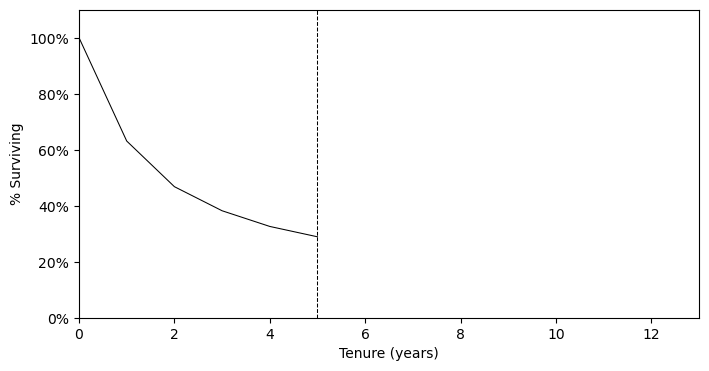

In [64]:
year, alive = np.loadtxt('data/hardie-sample-retention.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
year = year.astype(int)
alive = alive.astype(float)

train_marker_x = [5 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

surviving = alive / alive[0]

plt.figure(figsize=(8,4), dpi=100)
plt.plot(surviving[:6], "k-", linewidth=0.75)
plt.plot(train_marker_x, train_marker_y, "k--", linewidth=0.75)
plt.xlabel("Tenure (years)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.xlim(0, 13)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### Parametric Approach: Projecting Survival Using Simple Functions of Time - Linear Regression

The simplest and most intuitive approach to modeling customer retention to try to fit some known function to the retention curve. This approach is called **parametric statistics**, because a few parameters describe the shape of the function. The power of this approach is that we can use it to estimate what happens in the future. Using a single cohort data of active customers from acquisition to the end of an observed period we can compute a best-fit curve that minimizes the sum of squared errors. 

A **parametric approach** to modeling retention curves means selecting a specific functional form (or model) with a small number of parameters that can capture the retention dynamics over time. The functional form can be linear, quadratic, or exponential. By tuning the function's parameters, we aim to approximate the behavior of actual customer retention data. In the implementations below, the parameters are optimized to match the predicted retention curve with the observed data.

1) Linear Function Form: $R(t) = \beta_{0} + \beta_{1}t$
2) Quadratic Function Form: $R(t) = \beta_{0} + \beta_{1}t + \beta_{2}t^{2}$
3) Exponential Function Form: $R_{t} = e^{\beta_{0}+\beta_{1}t}$

In [65]:
import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore', category=UserWarning)

y = surviving[:5]

# Linear Function Regression
x = sm.add_constant(year[:5])   
linear_results = sm.OLS(y, x).fit()
print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     19.88
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0210
Time:                        21:50:45   Log-Likelihood:                 5.0720
No. Observations:                   5   AIC:                            -6.144
Df Residuals:                       3   BIC:                            -6.925
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8808      0.088     10.038      0.0

In [66]:
# Quadratic Function Regression
x = np.column_stack((year[:5], year[:5]**2))
x = sm.add_constant(x)
quadratic_results = sm.OLS(y, x).fit()
print(quadratic_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     90.91
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0109
Time:                        21:50:45   Log-Likelihood:                 11.295
No. Observations:                   5   AIC:                            -16.59
Df Residuals:                       2   BIC:                            -17.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9812      0.038     26.091      0.0

In [67]:
# Exponential Function Regression
x = year[:5]
x = sm.add_constant(x)
exponential_results = sm.OLS(np.log(surviving[:5]), x).fit()
print(exponential_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     62.14
Date:                Mon, 11 Nov 2024   Prob (F-statistic):            0.00425
Time:                        21:50:45   Log-Likelihood:                 5.2161
No. Observations:                   5   AIC:                            -6.432
Df Residuals:                       3   BIC:                            -7.213
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1119      0.085     -1.312      0.2

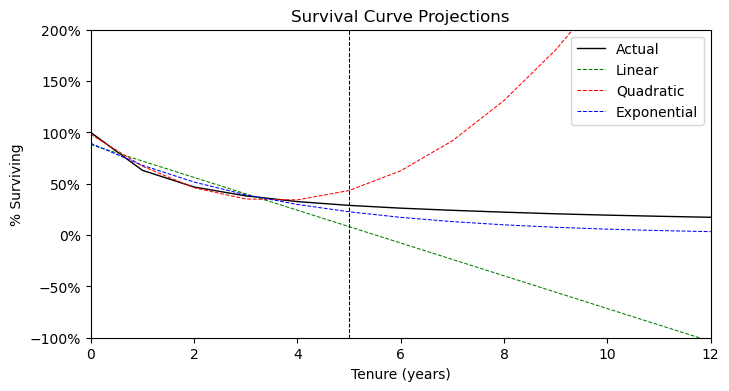

In [68]:
intercept, t_coeff = linear_results.params
y_lin = intercept + (t_coeff * year)
intercept, t_coeff, tsquare = quadratic_results.params
y_quad = intercept + t_coeff*year + tsquare*year**2
intercept, t_coeff = exponential_results.params
y_exp = np.exp(intercept + t_coeff*year)

train_marker_x = [5 for _ in np.arange(-1,2.1,0.1)]
train_marker_y = [_ for _ in np.arange(-1,2.1,0.1)]

surviving = alive / alive[0]

plt.figure(figsize=(8,4), dpi=100)
plt.title("Survival Curve Projections")
plt.plot(year, surviving, "k-", linewidth=1, label="Actual")
plt.plot(year, y_lin, "g--", linewidth=0.75, label="Linear")
plt.plot(year, y_quad, "r--", linewidth=0.75, label="Quadratic")
plt.plot(year, y_exp, "b--", linewidth=0.75, label="Exponential")
plt.plot(train_marker_x, train_marker_y, "k--", linewidth=0.75)
plt.xlabel("Tenure (years)")
plt.ylabel("% Surviving")
plt.ylim(-1,2)
plt.xlim(0, 12)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

The fit of all three models up to and including Year 4 is reasonable, and the quadratic model provides a particularly good fit (R-Squared = 0.989). But when we consider the projections beyond the model calibration period, all three models break down dramatically. The linear and exponential models underestimate Year 12 survival while the quadratic model overestimates Year 12 survival. Furthermore, the models lack logical consistency: The linear model would have $S(t) < 0$ after year 6, and according to the quadratic model the survivor function will start to increase over time, which is not possible. 

Of course, we could try out different arbitrary functions of time, but this would be a pure curve-fitting exercise at its worst. Furthermore, it is hard to imagine that there would be any underlying rationale for the equation(s) that we might settle upon.

### Shifted Geometric (SG) Model

In the three distinct implementation examples we look at:
- The first uses $x$ as a parameter, which represents a **monthly retention rate** which is obtained by minimizing the sum of squared errors between actual and predicted churn at each period and the number of survivors at the end of the period.
  - Models retention as a deterministic process of expected losses.
- The second uses $\theta$ as a parameter, which represents a **monthly churn probability** which is obtained by minimizing the sum of squared errors between actual and predicted retention at each period.
  - Focuses on fitting the retention rate proportionally.
- The third also uses $\theta$ as a parameter, which represents a **monthly churn probability** but is designed to maximize the log-likelihood function which represents the sum of the product of actual and log of the predicted churn and actual and log of the predicted survivors at the end of the period.
  - Assumes churn follows a probabilistic distribution, maximizing the likelihood of observed churn and survival.

These three implementations model customer retention using a shifted geometric approach. While each one approaches the calculation of retention and churn differently, they share the common goal of finding a parameter (`theta` or `x`) that best fits the data to a retention curve. Here’s a breakdown of their similarities and differences:

General overview of the three general methods implemented:

1. **Goal**: All three implementations aim to estimate a retention rate that minimizes the discrepancy between the model's prediction and the observed retention data. This is achieved through different error functions or likelihood calculations.
2. **Optimization**: All use `scipy.optimize.minimize` to find the optimal value for `theta` (or `x`), which represents the retention or churn parameter.
3. **Retention Model**: They each use a variation of a geometric retention model, where the probability of customers staying decreases over time at a certain rate.

**Implementation 1**: Sum of Squared Errors Using Expected Losses and Survivors

- **Objective**: This model minimizes the sum of squared errors (SSE) by comparing the *expected customer loss per month and the actual observed loss*. It also considers the *difference between expected and actual survivors at the end of the period*.
- **Expected Retention Calculation**: It calculates the expected retention each month based on `x`, then uses it to find the probability of churn (`p_churn`) and expected monthly losses (`en_loss`).
- **Error Calculation**: Combines the squared error for both customer loss and survivors to get an overall error.

**Implementation 2**: Direct Retention Comparison Using Monthly Retention Proportion

- **Objective**: This model also minimizes SSE but does so by directly comparing the retention rate over time with the model’s expected retention (`(1 - theta) ** month`).
- **Retention Calculation**: it calculate the actual retention rate, then calculates the model’s expected retention with the geometric formula. 
- **Error Calculation**: The function minimizes the SSE between the observed retention and the predicted retention directly.

**Implementation 3**: Log-Likelihood Maximization Using Probabilistic Churn

- **Objective**: Instead of minimizing SSE, this function *maximizes the log-likelihood function* for the observed retention data. This approach is more appropriate for use in a probabilistic model.
- **Churn Probability Calculation**: It calculates the probability of churn each month with a probabilistic model based on `theta`, which is the monthly churn rate.
- **Likelihood Components**: Calculates log-likelihood in two parts: 
  - **Churn**: The likelihood of observing the actual number of customers lost each period.
  - **Survivors**: The likelihood of the remaining customers staying until the end.
- **Error Calculation**: Returns the negative log-likelihood, which is minimized to find the best-fit `theta`.

These methods all aim to fit a shifted geometric retention curve but through different interpretations and optimization approaches, offering alternative ways to capture customer retention dynamics.

#### 1 Customer Segment - Geometric Curve Fitting with Retention Rate Parameter

In [69]:
month, alive = np.loadtxt('data/retention-example.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

In [70]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [71]:
def square_error(x):
    e_retention = np.ones_like(retention) * (x**month) # Expected monthly retention 
    p_churn = e_retention[:-1] - e_retention[1:] # Probability of monthly churn 
    en_loss = p_churn * alive[0] # Expected number of losses / month
    loss_error = np.sum((en_loss - loss)**2) # Sum of square of error - expected and actual loss
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2 # Sum of square of error - expected and actual survivors at the end of the period
    return loss_error + survivor_error

x_guess = 0.94
res = minimize(square_error, x_guess)
print('Predicted Monthly Retention Rate =', f'{res.x[0]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Predicted Monthly Retention Rate = 94.84%
Sum of Squared Errors = 272850400


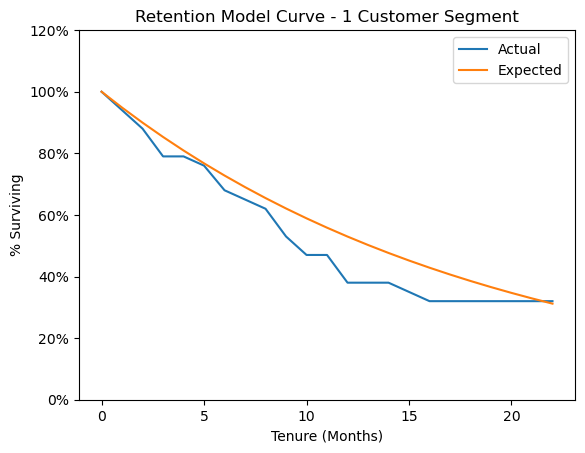

In [72]:
plt.plot(month, retention, label="Actual")
plt.plot(month, np.ones_like(retention) * (res.x**month), label="Expected")
plt.title('Retention Model Curve - 1 Customer Segment')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.2))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 2 Customer Segments - Geometric Curve Fitting with Retention Rate & Segment Proportion Parameters

In [73]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [74]:
def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[2]) + \
                  (np.ones_like(retention) * (x[1]**month) * (1 - x[2]))
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

# 3 Decision Variables: Retention rate for segment 1 & 2 and proportion of segment 1 customers
guesses = 0.95, 0.90, 0.20
bnds = ((0, 1), (0, 1), (0, 1))
res = minimize(square_error, x0=guesses, bounds=bnds) 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[2]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{1 - res.x[2]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

res

Monthly Retention Rate - Segment 1 = 100.00%
% of Customer - Segment 1 = 21.00%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 79.00%
Sum of Squared Errors = 252951531


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 252951531.12897995
        x: [ 1.000e+00  9.139e-01  2.100e-01]
      nit: 20
      jac: [-1.521e+08 -2.228e+04 -6.855e+03]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

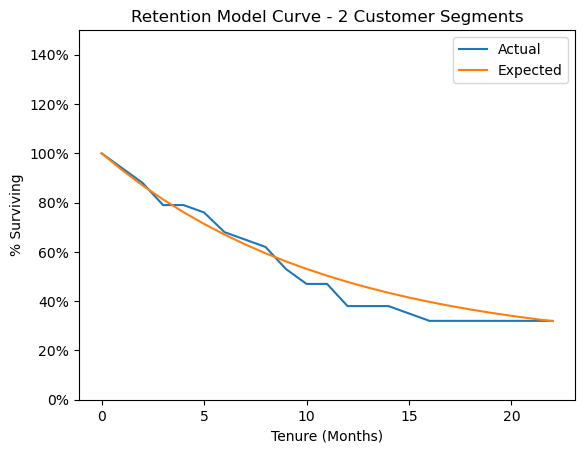

In [75]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[2]) + \
                (np.ones_like(retention) * (res.x[1]**month) * (1 - res.x[2]))
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 2 Customer Segments')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.5))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 3 Customer Segments - Geometric Curve Fitting with Retention Rate & Segment Proportion Parameters

In [76]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [77]:
from scipy.optimize import LinearConstraint

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[3]) + \
                  (np.ones_like(retention) * (x[1]**month) * x[4]) + \
                  (np.ones_like(retention) * (x[2]**month) * x[5])
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

guesses = np.array([0.90, 0.90, 0.90, 0.20, 0.30, 0.50])
bnds = np.array([(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)])
cons = LinearConstraint([0, 0, 0, 1, 1, 1], 1, 1) # Define the constraint: x[3] + x[4] + x[5] == 1
res = minimize(square_error, x0=guesses, bounds=bnds, constraints=[cons], method='trust-constr') 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[3]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{res.x[4]:0.2%}')
print('Monthly Retention Rate - Segment 3 =', f'{res.x[2]:0.2%}')
print('% of Customer - Segment 3 =', f'{res.x[5]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Monthly Retention Rate - Segment 1 = 91.39%
% of Customer - Segment 1 = 40.38%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 38.62%
Monthly Retention Rate - Segment 3 = 100.00%
% of Customer - Segment 3 = 21.00%
Sum of Squared Errors = 252951531


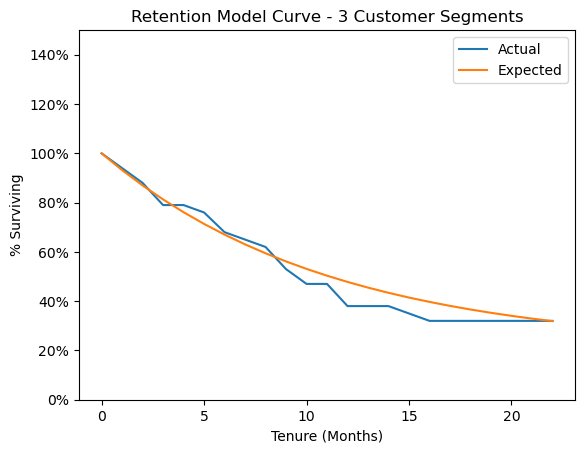

In [78]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[3]) + \
              (np.ones_like(retention) * (res.x[1]**month) * res.x[4]) + \
              (np.ones_like(retention) * (res.x[2]**month) * res.x[5])
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 3 Customer Segments')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.5))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [79]:
from scipy.optimize import LinearConstraint

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[3]) + \
                  (np.ones_like(retention) * (x[1]**month) * x[4]) + \
                  (np.ones_like(retention) * (x[2]**month) * (1-x[4]-x[3]))
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

guesses = np.array([0.90, 0.90, 0.90, 0.20, 0.30])
bnds = np.array([(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)])
cons = LinearConstraint([0, 0, 0, 1, 1], 1, 1)
res = minimize(square_error, x0=guesses, bounds=bnds, constraints=[cons], method='COBYQA') 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[3]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{res.x[4]:0.2%}')
print('Monthly Retention Rate - Segment 3 =', f'{res.x[2]:0.2%}')
print('% of Customer - Segment 3 =', f'{1-res.x[4]-res.x[3]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Monthly Retention Rate - Segment 1 = 100.00%
% of Customer - Segment 1 = 21.00%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 79.00%
Monthly Retention Rate - Segment 3 = 14.64%
% of Customer - Segment 3 = 0.00%
Sum of Squared Errors = 252951531


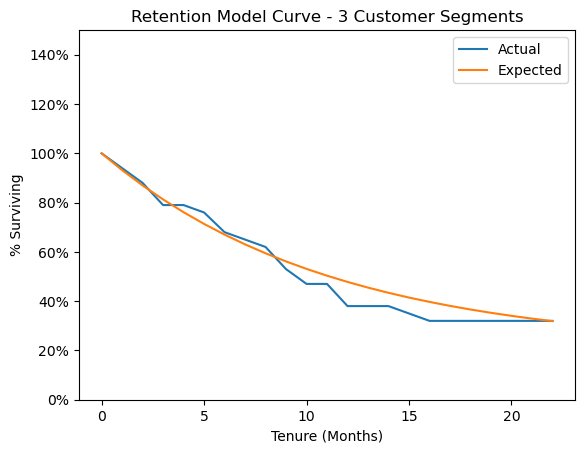

In [80]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[3]) + \
              (np.ones_like(retention) * (res.x[1]**month) * res.x[4]) + \
              (np.ones_like(retention) * (res.x[2]**month) * (1-res.x[4]-res.x[3]))
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 3 Customer Segments')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.5))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 1 Customer Segment - Exponential Curve Fitting with Churn Parameter

In [81]:
month, alive = np.loadtxt('data/DSC-retention-data.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

train_month = month[:8]
train_alive = alive[:8]

In [82]:
def square_error(theta):
    retention = train_alive / train_alive[0]
    e_retention = (1-theta)**train_month
    return np.sum((retention-e_retention)**2)

theta_guess = 0.5
res = minimize(square_error, theta_guess, bounds=[(0.000001,0.999999)])
theta = res.x[0]
print(f'{theta = :.1%}')
print(f'retention rate = {1-theta:.1%}')
print(f'SSE = {res.fun:.3%}')

theta = 11.2%
retention rate = 88.8%
SSE = 0.929%


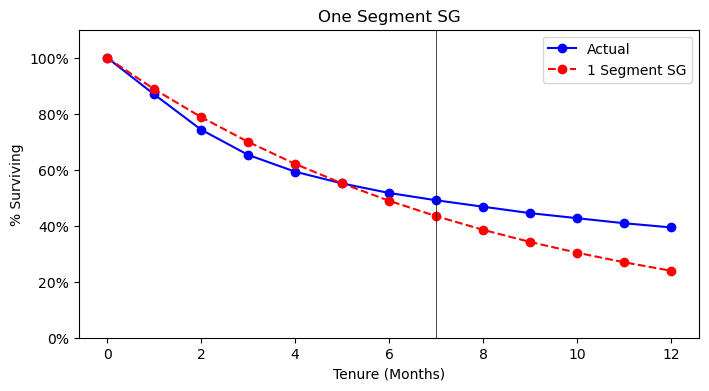

In [83]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
e_retention = (1-theta)**month

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-o", label='Actual')
plt.plot(e_retention, "r--o", label='1 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('One Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

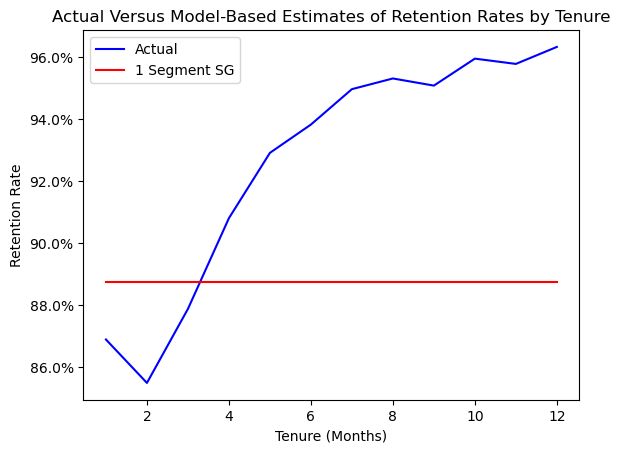

In [84]:
rr = alive[1:] / alive[:-1]
e_alive = alive[0] * e_retention
e_rr = e_alive[1:] / e_alive[:-1]

plt.title("Actual Versus Model-Based Estimates of Retention Rates by Tenure")
plt.plot(month[1:], rr, "b", label='Actual')
plt.plot(month[1:], e_rr, "r", label='1 Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("Retention Rate")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 2 Customer Segments - Exponential Curve Fitting with Churn & Segment Proportion Parameter

In [85]:
def square_error(x):
    retention = train_alive / train_alive[0]
    s1_retention = (1-x[1])**train_month
    s2_retention = (1-x[2])**train_month
    e_retention = s1_retention*x[0] + s2_retention*(1-x[0])
    return np.sum((retention-e_retention)**2)

guesses = [0.2, 0.1, 0.1]
bnd = [(0,1), (0,1), (0,1)]
res = minimize(square_error, guesses, bounds=bnd)

pi1, theta1, theta2 = res.x
print(f'{pi1 = :.1%}, {theta1 = :.1%}, rr = {1-theta1:.1%}\npi2 = {1-pi1:.1%}, {theta2 = :.1%}, rr = {1-theta2:.1%}')
print(f'SSE = {res.fun:.3%}')

pi1 = 40.6%, theta1 = 0.0%, rr = 100.0%
pi2 = 59.4%, theta2 = 24.6%, rr = 75.4%
SSE = 0.032%


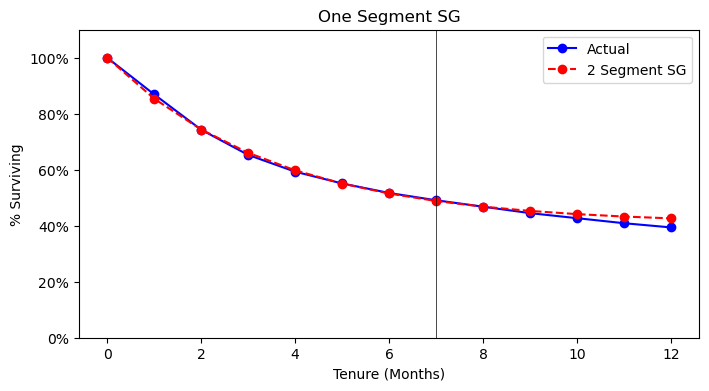

In [86]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
s1_retention = (1-theta1)**month
s2_retention = (1-theta2)**month
e_retention = s1_retention*pi1 + s2_retention*(1-pi1)

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-o", label='Actual')
plt.plot(e_retention, "r--o", label='2 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('One Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

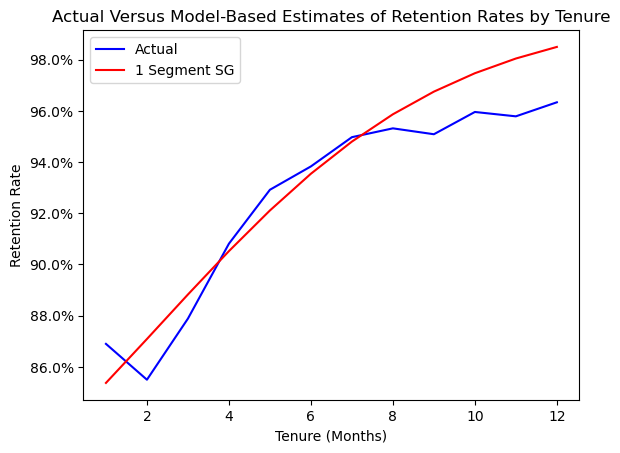

In [87]:
rr = alive[1:] / alive[:-1]
e_alive = alive[0] * e_retention
e_rr = e_alive[1:] / e_alive[:-1]

plt.title("Actual Versus Model-Based Estimates of Retention Rates by Tenure")
plt.plot(month[1:], rr, "b", label='Actual')
plt.plot(month[1:], e_rr, "r", label='1 Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("Retention Rate")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### Problem with Parametric Approach

The fit of all models up to and including Year 7 is reasonable, and the 2 segment geometric model provides a particularly good fit. But when we consider the projections beyond the model calibration period, all models break down dramatically with the 1 segment geometric function underestimating percentage survival while the 2 segment geometric function overestimating survival. This range of error may not be acceptable in most cases.

We need to look towards other probabilistic models of the survival function (or contract duration) that are based on a simple story of customer behavior. 

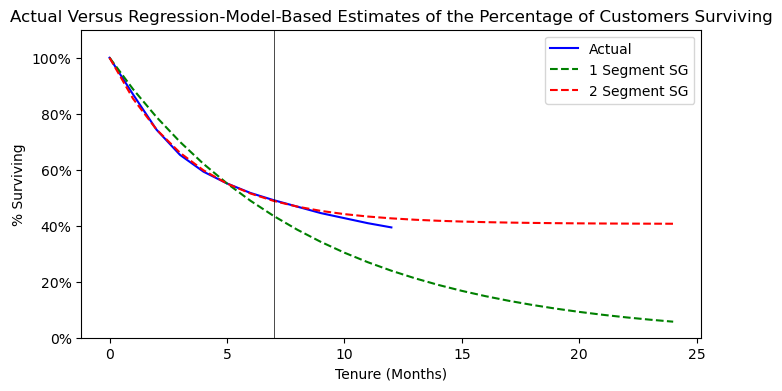

In [88]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
x_month = np.arange(0, 25, 1)

# 1 Segment SG
e_retention1 = (1-theta)**x_month

# 2 Segment SG
s1_retention = (1-theta1)**x_month
s2_retention = (1-theta2)**x_month
e_retention2 = s1_retention*pi1 + s2_retention*(1-pi1)

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-", label='Actual')
plt.plot(e_retention1, "g--", label='1 Segment SG')
plt.plot(e_retention2, "r--", label='2 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('Actual Versus Regression-Model-Based Estimates of the Percentage of Customers Surviving')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### Shifted Geometric - Probabilistic distribution, Maximize the likelihood of Observed Churn and Survival

At the end of each contract period, a customer makes the renewal decision by tossing a coin: H → renew, T → don’t renew

| Length of Relationship | |
| ------|----|
| 1 Period | T |
| 2 period | H T |
| 3 Period | H H T |

$$
P(t\space\text{periods}) = 
     \begin{cases}
       P(T) &\quad t=1\\
       P(H) \times P(t-1\space\text{periods}) &\quad t=2,3,\cdots \\
     \end{cases}
$$

**Model**:
- $P(H)=1−\theta$ is constant and unobserved.
- All customers have the same "churn probability" $\theta$.
- Let the random variable $T$ denote the duration of the customer’s relationship with the firm.
- We assume that the random variable $T$ is distributed geometric with parameter $\theta$:
$$P(T=t|\theta)=\theta(1-\theta)^{t-1}, \space t=1,2,3,\cdots$$
$$S(t|\theta)=P(T>t|\theta) = (1-\theta)^{t}, \space t=0,1,2,3,\cdots$$

**Assumptions**:
- The observed data were generated according to the “coin flipping” story of contract renewal, and
- we know $P(T)=\theta$, the probability of the observed pattern of renewals is:
$$[P(T=1|\theta)]^{369}[P(T=2|\theta)]^{163}[P(T=3|\theta)]^{86}[P(T=4|\theta)]^{56}[S(t|\theta)]^{326}=\\
[\theta]^{369}[\theta(1-\theta)]^{163}[\theta(1-\theta)^{2}]^{86}[\theta(1-\theta)^{3}]^{56}[\theta(1-\theta)^{4}]^{326}$$

Suppose we have two candidate coins:
- Coin A: $\theta = 0.2$
- Coin B: $\theta = 0.5$

Which coin is more likely to have generated the observed pattern of renewals across this set of 1000 customers?

| θ | P(data \| θ) | ln[P(data \| θ)]|
|-----|----------------|---------|
| 0.2 | 6.00 x 10^(-647) | -1488.0 |
| 0.5 | 1.40 x 10^(-747) | -1718.7 |

We estimate the model parameters using the method of **maximum likelihood**:
- The likelihood function is defined as the probability of observing the data for a given set of the (unknown) model parameters.
- It is computed using the model and is viewed as a function of the model parameters:
$$L(\text{parameters}| \text{data})= p(\text{data} | \text{parameters}).$$
- For a given dataset, the maximum likelihood estimates of the model parameters are those values that maximize $L( \cdot )$.
- It is typically more convenient to use the **natural logarithm of the likelihood function** — the **log-likelihood** function.

The log-likelihood function is given by:
$$
LL(θ|data)=369 \times ln[P(T=1 |θ)]+\\
163 \times ln[P(T=2 |θ)]+\\
86 \times ln[P(T=3 |θ)]+\\
56 \times ln[P(T=4 |θ)]+\\
326 \times ln[S(4 |θ)]
$$
The maximum value of the log-likelihood function is
$LL = −1451.2$, which occurs at $\theta = 0.272$.

In [89]:
year, alive = np.loadtxt('data/hardie-sample-retention.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
year = year.astype(int)
alive = alive.astype(float)
train_year = year[:5]
train_alive = alive[:5]

In [122]:
def log_likelihood(theta):
    n_lost = train_alive[:-1] - train_alive[1:]
    p_churn = theta * (1 - theta)**(train_year - 1)
    ll_churn = np.sum(n_lost * np.log(p_churn[1:]))
    ll_alive = train_alive[-1] * np.log((1-theta)**train_year[-1])
    return -(ll_churn + ll_alive)

guess = 0.5
bnds = [(0.00001,0.99999)]
result = minimize(log_likelihood, guess, bounds=bnds)
theta, ll = result.x, result.fun
print(f'θ = {theta[0]:.3f}')
print(f'log-likelihood = {-ll:0.1f}')

θ = 0.272
log-likelihood = -1451.2


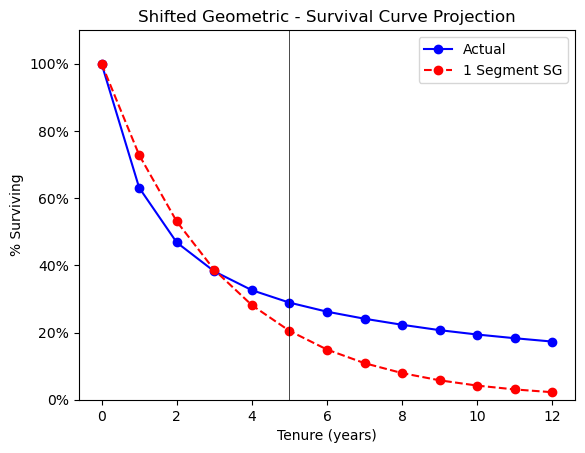

In [91]:
train_marker_x = [5 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
e_retention = (1-theta)**year

#plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-o", label='Actual')
plt.plot(e_retention, "r--o", label='1 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('Shifted Geometric - Survival Curve Projection')
plt.xlabel("Tenure (years)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

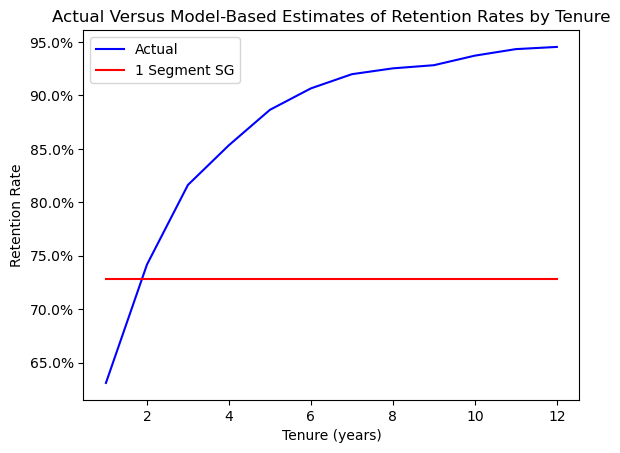

In [121]:
rr = alive[1:] / alive[:-1]
e_alive = alive[0] * e_retention
e_rr = e_alive[1:] / e_alive[:-1]

plt.title("Actual Versus Model-Based Estimates of Retention Rates by Tenure")
plt.plot(year[1:], rr, "b", label='Actual')
plt.plot(year[1:], e_rr, "r", label='1 Segment SG')
plt.xlabel("Tenure (years)")
plt.ylabel("Retention Rate")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

Text(0, 0.5, '$ln[P(\\text{data})]$')

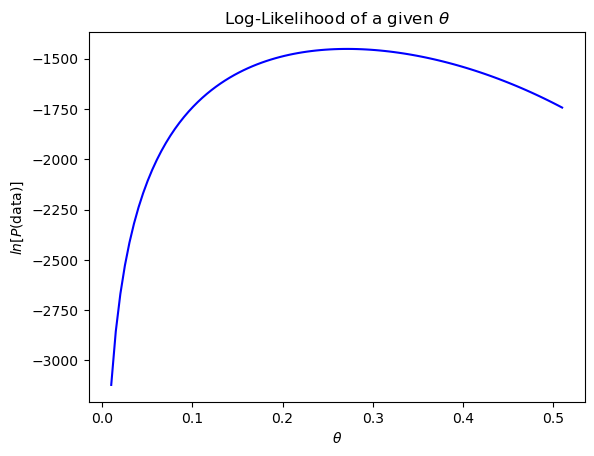

In [120]:
def log_likelihood(theta):
    n_lost = train_alive[:-1] - train_alive[1:]
    p_churn = theta * (1 - theta)**(train_year - 1)
    ll_churn = np.sum(n_lost * np.log(p_churn[1:]))
    ll_alive = train_alive[-1] * np.log((1-theta)**train_year[-1])
    return (ll_churn + ll_alive)

theta_x = np.linspace(0.01, 0.51, 100)
ll_y = np.vectorize(log_likelihood)(theta_x)

plt.title("Log-Likelihood of a given $θ$")
plt.plot(theta_x, ll_y, "b")
plt.xlabel("$θ$")
plt.ylabel("$ln[P(\\text{data})]$")

### Shifted Beta Geometric (sBG) Model 

The shifted beta geometric model (sBG) is a model that is used to forecast retention/survival of users in contractual settings (think netflix, disney plus, tinder gold, etc). The model is quite simple and posits:
- At the end of each period, a customer flips a coin: “heads” she cancels he contract, “tails” she renews it.
- For each individual, the probability of a coin coming up “heads” does not change over time
- The probability of heads varies across customers. 

The two things we need are the probability density function and the survival function. Mathematically, the probability density and survival function are:
$$P(T=t \mid \alpha, \beta) = \dfrac{B(\alpha+1, \beta+t-1)}{B(\alpha, \beta)}$$
$$S(T=t \mid \alpha, \beta) = \dfrac{B(\alpha, \beta+t)}{B(\alpha, \beta)}$$

Here, $B(\alpha, \beta)$ is the beta function and not the beta distribution.

#### Shifted-Beta-Geometric (sBG)